<a href="https://colab.research.google.com/github/saanvi0204/credit_card_fraud_detection/blob/main/fine_tuning_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import csv
import random
import time
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from lightgbm import LGBMClassifier

# --- Setup ---
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s:%(message)s')
logger = logging.getLogger(__name__)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [ ]:
# Paths
data_path = Path('/content/drive/MyDrive/Autoencoders/Credit card fraud detection/processed_df.csv')
model_path = Path('/content/drive/MyDrive/Autoencoders/Credit card fraud detection/best_ae_model1.keras')
log_csv = Path('/content/drive/MyDrive/Autoencoders/Credit card fraud detection/experiment_results.csv')

# Validate paths
assert data_path.exists(), f"Data file not found: {data_path}"
assert model_path.exists(), f"Model file not found: {model_path}"

In [ ]:
logger.info("Loading data and autoencoder model...")
df = pd.read_csv(data_path)
ae = load_model(model_path)
encoder = Model(inputs=ae.input, outputs=ae.layers[1].output)

In [ ]:
# Prepare raw features and labels
y = df['Class'].values
X_raw = df.drop('Class', axis=1).values

# Global scaling
scaler = StandardScaler().fit(X_raw)
X_scaled = scaler.transform(X_raw)

In [ ]:
# Extract AE features + reconstruction error
def extract_features(ae, enc, X):
    pred = ae.predict(X, batch_size=1024)
    error = np.mean(np.abs(X - pred), axis=1).reshape(-1,1)
    latent = enc.predict(X, batch_size=1024)
    return np.hstack([latent, error])

X_feat = extract_features(ae, encoder, X_scaled)

279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Initialize CSV logger
with open(log_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([
        'fold',
        'lgbm_best_params',
        'rf_best_params',
        'threshold',
        'Accuracy', 'TPR', 'TNR', 'F1', 'MCC'
    ])

[LightGBM] [Info] Number of positive: 314, number of negative: 181962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


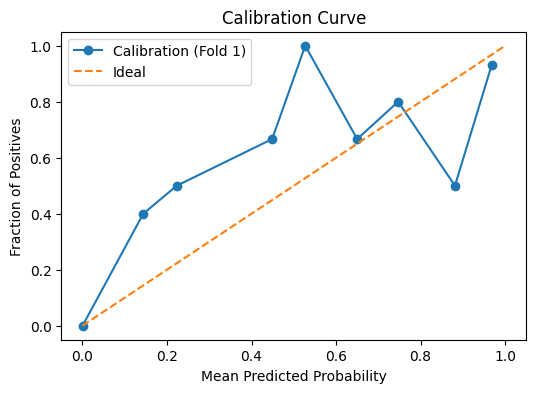

[LightGBM] [Info] Number of positive: 314, number of negative: 181962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 315, number of negative: 181961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [In

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_feat, y), 1):
    logger.info(f"--- Fold {fold} ---")
    X_train_full, y_train_full = X_feat[train_idx], y[train_idx]
    X_test, y_test = X_feat[test_idx], y[test_idx]

    # Train/Calibration split
    X_train, X_calib, y_train, y_calib = train_test_split(
        X_train_full, y_train_full,
        test_size=0.2, stratify=y_train_full,
        random_state=RANDOM_STATE
    )

    # Hyperparameter tuning for LGBM
    lgbm = LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE)
    lgbm_param_dist = {
        'num_leaves': [20, 30, 40],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 150]
    }
    lgbm_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=lgbm_param_dist,
        n_iter=6,
        scoring='matthews_corrcoef',
        cv=3,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    lgbm_search.fit(X_train, y_train)
    best_lgbm = lgbm_search.best_estimator_
    logger.info(f"Fold {fold} LGBM best params: {lgbm_search.best_params_}")

    # Hyperparameter tuning for Random Forest
    rf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
    rf_param_dist = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    rf_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=rf_param_dist,
        n_iter=6,
        scoring='matthews_corrcoef',
        cv=3,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf_search.fit(X_train, y_train)
    best_rf = rf_search.best_estimator_
    logger.info(f"Fold {fold} RF best params: {rf_search.best_params_}")

    # Stacking classifier
    stack = StackingClassifier(
        estimators=[('lgbm', best_lgbm), ('rf', rf)],
        final_estimator=LogisticRegression(),
        cv=3,
        n_jobs=-1,
        passthrough=False
    )
    stack.fit(X_train, y_train)

    # Calibration (Platt scaling)
    prob_calib = stack.predict_proba(X_calib)[:,1]
    calibrator = LogisticRegression().fit(prob_calib.reshape(-1,1), y_calib)

    # Threshold tuning on calibration
    thresholds = np.linspace(0,1,200)
    mccs = [ matthews_corrcoef(y_calib, (prob_calib>=t).astype(int)) for t in thresholds ]
    best_t = thresholds[np.argmax(mccs)]
    logger.info(f"Fold {fold} best threshold: {best_t:.3f}")

    # Evaluate on test
    prob_test = stack.predict_proba(X_test)[:,1]
    prob_test_cal = calibrator.predict_proba(prob_test.reshape(-1,1))[:,1]
    y_pred = (prob_test_cal >= best_t).astype(int)

    acc = accuracy_score(y_test, y_pred)
    tpr = recall_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tnr = tn/(tn+fp)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Log results
    with open(log_csv, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            fold,
            lgbm_search.best_params_,
            rf_search.best_params_,
            best_t,
            acc, tpr, tnr, f1, mcc
        ])

    # Plot calibration curve for first fold
    if fold == 1:
        frac_pos, mean_pred = calibration_curve(y_calib, prob_calib, n_bins=10)
        plt.figure(figsize=(6,4))
        plt.plot(mean_pred, frac_pos, marker='o', label='Calibration (Fold 1)')
        plt.plot([0,1],[0,1], linestyle='--', label='Ideal')
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve')
        plt.legend()
        plt.show()

In [ ]:
logger.info(f"Experiment results saved to {log_csv}")

In [ ]:
import joblib

# After fitting `stack` and `calibrator` on your full training + calib data:
joblib.dump(stack,  '/content/drive/MyDrive/Autoencoders/Credit card fraud detection/ccfd_stack_model.pkl')
joblib.dump(calibrator, '/content/drive/MyDrive/Autoencoders/Credit card fraud detection/ccfd_calibrator.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/Autoencoders/Credit card fraud detection/ccfd_scaler.pkl')

['/content/drive/MyDrive/Autoencoders/Credit card fraud detection/ccfd_scaler.pkl']